In [70]:
import glob
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import os
import pathlib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [71]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanvipenumudy","key":"060d385c034df0a67a1402a323b1867e"}'}

In [72]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [73]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:13<00:00, 141MB/s]
100% 1.21G/1.21G [00:13<00:00, 94.2MB/s]


In [74]:
!ls

gtzan-dataset-music-genre-classification.zip  kaggle.json  sample_data


In [75]:
!unzip "gtzan-dataset-music-genre-classification.zip" -d /tmp

Archive:  gtzan-dataset-music-genre-classification.zip
replace /tmp/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /tmp/Data/features_30_sec.csv  
  inflating: /tmp/Data/features_3_sec.csv  
  inflating: /tmp/Data/genres_original/blues/blues.00000.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00001.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00002.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00003.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00004.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00005.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00006.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00007.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00008.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00009.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00010.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00011.wav  
  inflating: /tmp/Dat

In [77]:
import os
print(len(os.listdir('/tmp/Data/genres_original')))
print(len(os.listdir('/tmp/Data/genres_original/blues')))
print(len(os.listdir('/tmp/Data/genres_original/classical')))

10
100
100


In [112]:
temp = '/tmp/Data/genres_original/blues/blues.00083.wav'
x, sr = librosa.load(temp)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [113]:
x

array([-0.0244751 , -0.0541687 , -0.08081055, ..., -0.10940552,
       -0.03323364, -0.1116333 ], dtype=float32)

In [118]:
fft = np.fft.fft(x)
magnitude = np.abs(fft)
magnitude

array([506.34347534, 123.21916689,  62.34703637, ...,   1.58742823,
        62.34703637, 123.21916689])

In [116]:
freq = np.linspace(0,sr,len(magnitude))
freq

array([0.00000000e+00, 3.33185754e-02, 6.66371509e-02, ...,
       2.20499334e+04, 2.20499667e+04, 2.20500000e+04])

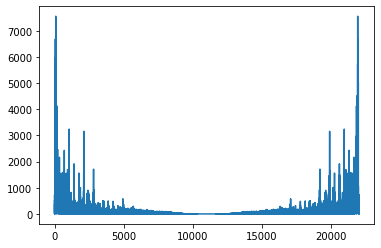

In [117]:
plt.plot(freq, magnitude)
plt.show()

In [79]:
import IPython.display as ipd
ipd.Audio(temp)

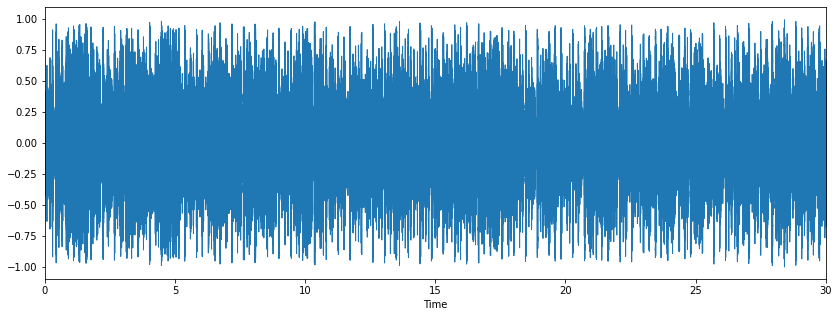

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

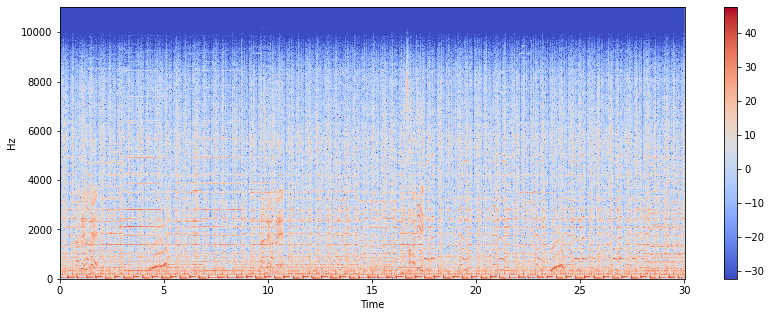

In [81]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [82]:
chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)

In [83]:
print(np.mean(chroma_stft))
chroma_stft

0.42729119553154565


array([[0.305578  , 0.16386828, 0.096196  , ..., 0.74357094, 0.63934547,
        0.63967665],
       [0.21223763, 0.08939307, 0.05463976, ..., 0.22772923, 0.1415322 ,
        0.20513097],
       [0.31415284, 0.12516046, 0.08737373, ..., 0.19376279, 0.29017025,
        0.35841229],
       ...,
       [0.18241952, 0.0669887 , 0.09131885, ..., 0.44502682, 0.24289955,
        0.22712334],
       [0.13311802, 0.0334558 , 0.06026515, ..., 0.36353006, 0.1499852 ,
        0.13351478],
       [0.18311652, 0.06156619, 0.05560324, ..., 0.49436007, 0.31281873,
        0.31477834]])

In [84]:
import csv

In [85]:
header = ['filename','chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zero_crossing_rate']
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'

In [85]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = ['blues','classical','country','disco','hiphop','metal','pop','reggae','rock']
for g in genres:
    for filename in os.listdir(f'/tmp/Data/genres_original/{g}'):
        songname = f'/tmp/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, momo=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [92]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00007.wav,0.307955,0.131822,1451.667066,1577.270941,2954.836760,0.061442,-179.347149,136.469013,-26.673135,39.984244,5.304419,10.928610,-20.564827,8.511156,-11.357249,-3.468347,-8.419937,-6.949716,-3.539139,-8.041618,-8.960675,-8.426084,-10.568936,-10.784516,-4.690677,-8.630722,blues
1,blues.00055.wav,0.432937,0.157742,2032.001859,1976.383235,4023.561440,0.113119,-98.743446,104.793649,-35.098252,60.701811,-2.833250,22.234495,-7.831172,19.035851,-11.573603,17.018518,-5.376152,12.200969,-9.956366,0.353348,-4.268689,6.133699,-4.822605,1.500582,-1.493840,3.509201,blues
2,blues.00070.wav,0.322809,0.106137,2159.392000,2130.224381,4684.529188,0.098348,-133.015971,105.734450,-22.149999,41.831103,-26.984577,19.115876,-26.562516,19.230763,-15.338012,6.986511,-10.808672,6.796417,-11.725246,4.393898,-6.027783,1.961996,-12.309117,3.256355,-8.804639,-3.371867,blues
3,blues.00001.wav,0.340914,0.095948,1530.176679,2039.036516,3550.522098,0.056040,-207.501685,123.991259,8.955128,35.877647,2.907321,21.510467,-8.560437,23.370686,-10.099661,11.900497,-5.555638,5.376327,-2.231760,4.220140,-6.012149,0.927997,-0.731124,0.295072,-0.283518,0.531216,blues
4,blues.00064.wav,0.332650,0.117432,2553.361183,2280.266170,5148.375700,0.146833,-85.108766,88.799706,-16.312861,59.226771,-35.976449,14.388841,-22.294800,9.654231,-14.818461,11.175134,-14.799717,8.472941,-19.585276,6.412785,-13.775700,6.113826,-13.147978,3.931494,-7.612430,3.752393,blues


In [93]:
data.shape

(900, 28)

In [94]:
data = data.drop(['filename'],axis=1)

In [95]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [97]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [100]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(675, 26) (225, 26) (675,) (225,)


In [101]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([71, 73, 75, 74, 66, 79, 81, 76, 80]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([29, 27, 25, 26, 34, 21, 19, 24, 20]))


In [102]:
from keras.utils import to_categorical

In [103]:
#One-hot encoding 
print("Before:", y_train.shape)
print("Before:", y_test.shape)
y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)
print("After: ", y_train.shape)
print("After: ", y_test.shape)

Before: (675,)
Before: (225,)
After:  (675, 9)
After:  (225, 9)


In [104]:
from keras import models
from keras import layers

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))                           
model.add(Dense(256, activation='relu'))   
model.add(Dense(128, activation='relu'))                           
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [105]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [106]:
history = model.fit(X_train,y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=128)

Epoch 1/100
6/6 [==============================] - 0s 25ms/step - loss: 2.1154 - accuracy: 0.2533 - val_loss: 1.9539 - val_accuracy: 0.2844
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 1.8509 - accuracy: 0.3852 - val_loss: 1.8009 - val_accuracy: 0.3378
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.6440 - accuracy: 0.4622 - val_loss: 1.6453 - val_accuracy: 0.4044
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 1.4551 - accuracy: 0.4919 - val_loss: 1.5001 - val_accuracy: 0.4889
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 1.2746 - accuracy: 0.5941 - val_loss: 1.3451 - val_accuracy: 0.5289
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 1.1114 - accuracy: 0.6444 - val_loss: 1.2520 - val_accuracy: 0.5600
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0163 - accuracy: 0.6533 - val_loss: 1.1681 - val_accuracy: 0.5778
Epoch 8/100
6/6 [=========